In [1]:
import numpy as np
import pandas as pd
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence

In [3]:
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import cv2

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

import os

import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import files

In [6]:
uploaded = files.upload()

Saving BiPuMoZa.zip to BiPuMoZa.zip


In [7]:
import zipfile

zip_path = list(uploaded.keys())[0]  # Get the path of the uploaded ZIP file
extract_path = '/content/BiPuMoZa'  # Specify the path to extract the contents

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [8]:
train_dir = '/content/BiPuMoZa/BiPuMoZa/train'
test_dir = '/content/BiPuMoZa/BiPuMoZa/train'

train_class = os.listdir(train_dir)
print(train_class)

test_class = os.listdir(test_dir)
print(test_class)

['putin', 'zal', 'biden', 'modi']
['putin', 'zal', 'biden', 'modi']


In [16]:
from PIL import Image, UnidentifiedImageError

x = []  # array value of the images
y = []  # the labels of the images

for folder in os.listdir(train_dir):
    if os.path.isdir(os.path.join(train_dir, folder)):
        image_list = os.listdir(os.path.join(train_dir, folder))
        for img_name in image_list:
            if not img_name.startswith('.'):  # Skip files starting with '.'
                try:
                    # Loading images
                    img = Image.open(os.path.join(train_dir, folder, img_name))
                    img = img.resize((224, 224))  # Resizing the image
                    img = image.img_to_array(img)

                    # Transfer Learning: Preprocess of MobileNetV2 model to our images before passing it to MobileNetV2
                    img = preprocess_input(img)

                    x.append(img)  # appending image array
                    y.append(train_class.index(folder))  # appending class index to the array
                except (UnidentifiedImageError, OSError) as e:
                    print(f"Skipping image: {img_name} in folder: {folder}. Error: {str(e)}")

print("Preparing Training Dataset Completed.")

Preparing Training Dataset Completed.


In [18]:
test_images = []
test_images_Original = []
test_image_label = []

for folder in os.listdir(test_dir):
    if os.path.isdir(os.path.join(test_dir, folder)):
        image_list = os.listdir(os.path.join(test_dir, folder))
        for img_name in image_list:
            if not img_name.startswith('.'):  # Skip files starting with '.'
                try:
                    # Loading images
                    img = image.load_img(os.path.join(test_dir, folder, img_name), target_size=(224, 224))

                    # Converting to arrays
                    img_array = image.img_to_array(img)

                    # Saving original images, will be used just for display at the end
                    test_images_Original.append(img_array.copy())

                    # Preprocessing with MobileNetV2 model
                    img_array = preprocess_input(img_array)

                    # Appending arrays
                    test_images.append(img_array)
                    test_image_label.append(test_class.index(folder))
                except (UnidentifiedImageError, OSError) as e:
                    print(f"Skipping image: {img_name} in folder: {folder}. Error: {str(e)}")

print("Preparing Test Dataset Completed.")

Preparing Test Dataset Completed.


In [19]:
print("Training Dataset")

x = np.array(x)  # Converting to np array to pass to the model
print(x.shape)

y = to_categorical(y)  # One-hot encoding of the labels
print(y.shape)

print("Test Dataset")

test_images = np.array(test_images)
print(test_images.shape)

test_image_label = to_categorical(test_image_label)  # One-hot encoding of the labels
print(test_image_label.shape)

Training Dataset
(2023, 224, 224, 3)
(2023, 4)
Test Dataset
(2023, 224, 224, 3)
(2023, 4)


In [20]:
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.2, random_state=5)
print("Splitting data for train and val completed.")

Splitting data for train and val completed.


In [26]:
biden_dir = "/content/BiPuMoZa/BiPuMoZa/train/biden"
putin_dir = "/content/BiPuMoZa/BiPuMoZa/train/putin"
modi_dir = "/content/BiPuMoZa/BiPuMoZa/train/modi"
zal_dir = "/content/BiPuMoZa/BiPuMoZa/train/zal"

rand_images1 = random.sample(os.listdir(biden_dir), 8)
rand_images2 = random.sample(os.listdir(putin_dir), 8)
rand_images3 = random.sample(os.listdir(modi_dir), 8)
rand_images4 = random.sample(os.listdir(zal_dir), 8)

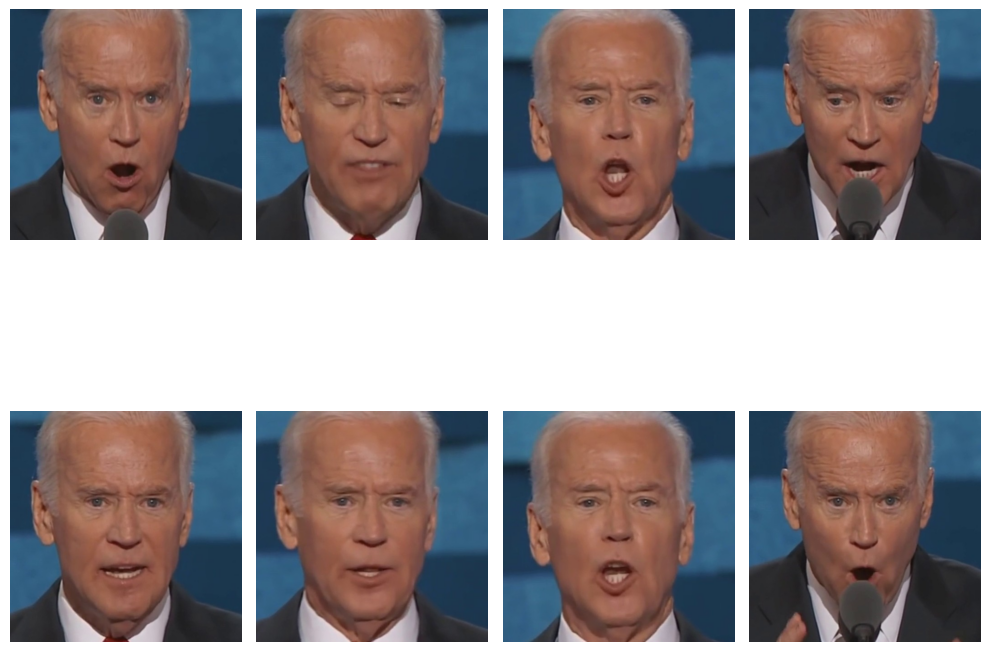

In [27]:
fig = plt.figure(figsize=(10, 10))
for i, im in enumerate(rand_images1):
    plt.subplot(2, 4, i+1)
    img_path = os.path.join(biden_dir, im)
    im = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.tight_layout()
plt.show()

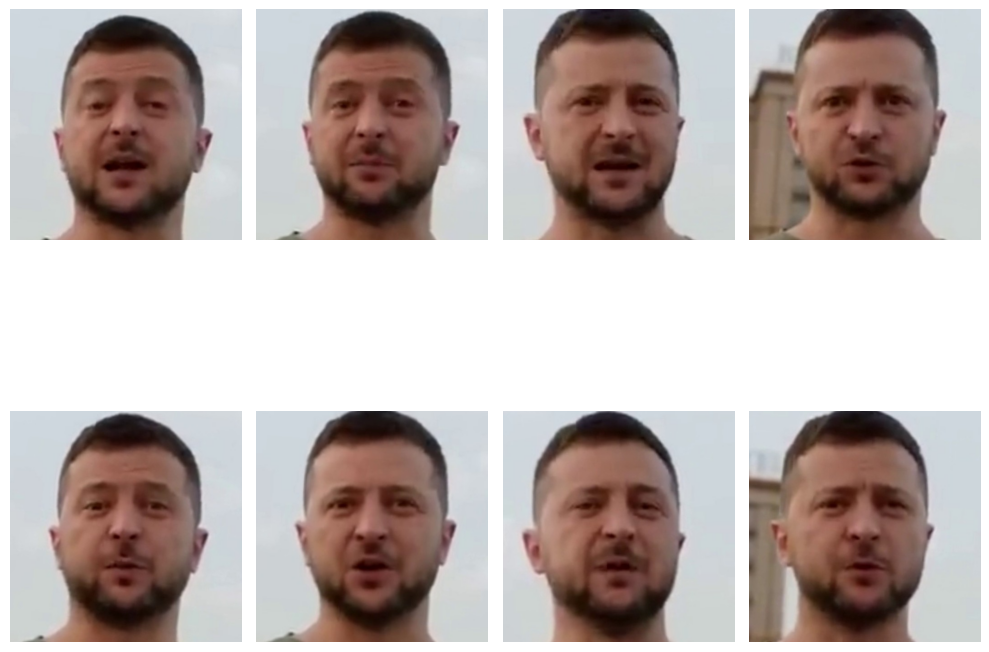

In [29]:
fig = plt.figure(figsize=(10, 10))
for i, im in enumerate(rand_images4):
    plt.subplot(2, 4, i+1)
    img_path = os.path.join(zal_dir, im)
    im = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
mnet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [31]:
from tensorflow.keras import backend as K

# Clear Keras backend session
K.clear_session()

model = Sequential([
    mnet,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.1),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(4, activation="softmax")
])

model.layers[0].trainable = False

model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [32]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the batch size for training
batch_size = 64

# Create an instance of the ImageDataGenerator with desired augmentation options
datagen = ImageDataGenerator(
    rotation_range=180,  # Randomly rotate images within the range of 180 degrees
    width_shift_range=1.0,  # Randomly shift images horizontally by a fraction of the total width
    height_shift_range=1.5,  # Randomly shift images vertically by a fraction of the total height
    zoom_range=0.5,  # Randomly zoom images by a factor of 0.4
    horizontal_flip=True  # Randomly flip images horizontally
)

# Compute the number of steps per epoch based on the batch size
steps_per_epoch = len(xtrain) // batch_size

# Create a generator for augmented data
augmented_data_generator = datagen.flow(xtrain, ytrain, batch_size=batch_size)

# Train the model with augmented data generator
hist = model.fit(augmented_data_generator, steps_per_epoch=steps_per_epoch, epochs=5, callbacks=[lr_callbacks], validation_data=(xval, yval))

Epoch 1/5
25/25 [==============================] - 116s 5s/step - loss: 0.0195 - accuracy: 0.9923 - val_loss: 0.0087 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 2/5
25/25 [==============================] - 104s 4s/step - loss: 0.0221 - accuracy: 0.9955 - val_loss: 0.0100 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 3/5
25/25 [==============================] - 110s 5s/step - loss: 0.0280 - accuracy: 0.9891 - val_loss: 0.0110 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 4/5
25/25 [==============================] - 108s 4s/step - loss: 0.0185 - accuracy: 0.9929 - val_loss: 0.0107 - val_accuracy: 0.9975 - lr: 1.0000e-04
Epoch 5/5
25/25 [==============================] - 108s 4s/step - loss: 0.0138 - accuracy: 0.9968 - val_loss: 0.0111 - val_accuracy: 0.9975 - lr: 1.0000e-04


In [46]:
# Save the training history to a file
import pickle

with open('training_history.pkl', 'wb') as file:
    pickle.dump(hist.history, file)

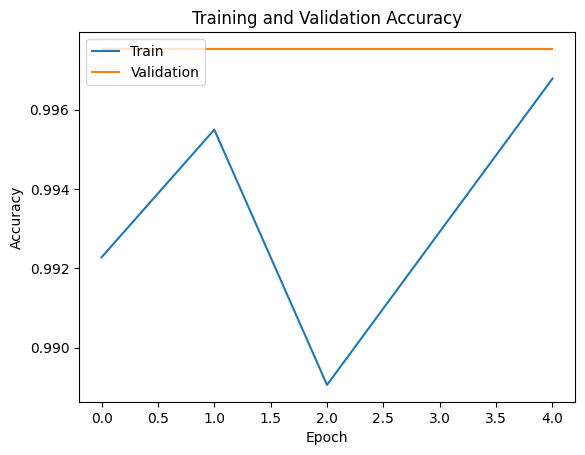

In [47]:
# Load the saved training history
with open('training_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Plot training and validation accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [48]:
def predict(img_name, model):
    img = image.load_img(img_name, target_size=(224, 224))
    img = image.img_to_array(img)
    plt.imshow(img.astype('uint8'))
    plt.show()
    img = preprocess_input(img)
    prediction = model.predict(img.reshape(1, 224, 224, 3))
    output = np.argmax(prediction)
    print(train_class[output])

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.astype('uint8'))
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)

In [49]:
# Preparing prediction array
predictions = []

for img in test_images:
    img = img.reshape(1, 224, 224, 3)
    predictions.append(model.predict(img))

1/1 [==============================] - 0s 59ms/step


In [50]:
pred_labels = model.predict(test_images)

64/64 [==============================] - 85s 1s/step


In [51]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_image_label, pred_labels, target_names=test_class))

              precision    recall  f1-score   support

       putin       1.00      1.00      1.00       506
         zal       1.00      1.00      1.00       503
       biden       1.00      1.00      1.00       504
        modi       1.00      1.00      1.00       510

   micro avg       1.00      1.00      1.00      2023
   macro avg       1.00      1.00      1.00      2023
weighted avg       1.00      1.00      1.00      2023
 samples avg       1.00      1.00      1.00      2023



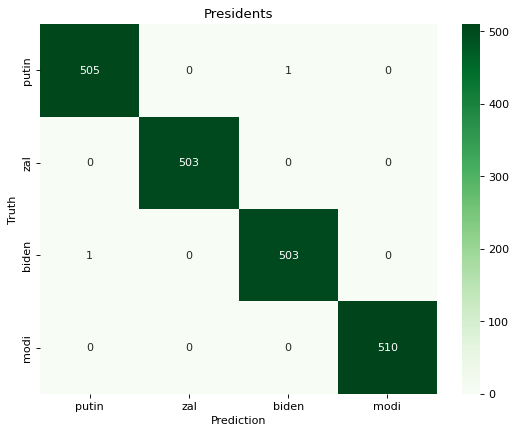

In [52]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_image_label, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= test_class,
                yticklabels=test_class)

plt.title('Presidents')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

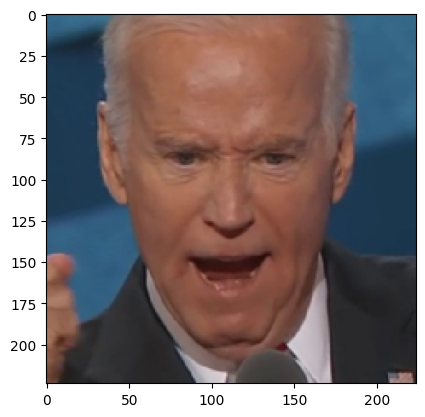

1/1 [==============================] - 0s 64ms/step
biden


In [53]:
predict("/content/BiPuMoZa/BiPuMoZa/test/biden/00507_0.jpg", model)

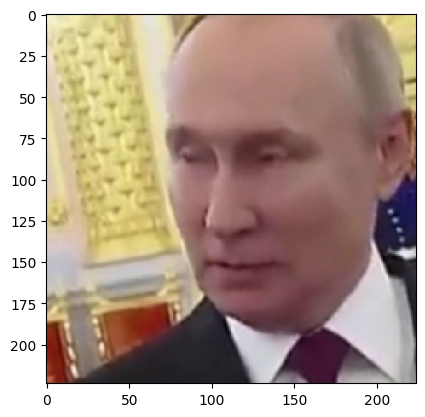

1/1 [==============================] - 0s 60ms/step
putin


In [59]:
predict("/content/BiPuMoZa/BiPuMoZa/test/putin/00777_0.jpg", model)

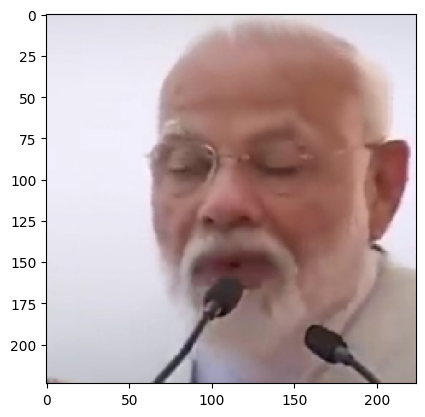

1/1 [==============================] - 0s 64ms/step
modi


In [60]:
predict("/content/BiPuMoZa/BiPuMoZa/test/modi/00690_0.jpg", model)

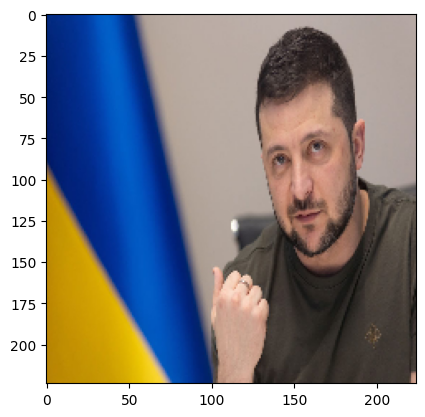

1/1 [==============================] - 0s 126ms/step
zal


In [62]:
predict("/content/BiPuMoZa/BiPuMoZa/train/zal/zal2.jpg", model)